In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 32.8 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt



In [ ]:
asset='AMZN'
start_date='2019-01-01'
end_date='2019-07-31'

In [ ]:
df=yf.download(asset,start=start_date,end=end_date,adjusted=True)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,1465.199951,1553.359985,1460.930054,1539.130005,1539.130005,7983100
2019-01-03,1520.010010,1538.000000,1497.109985,1500.280029,1500.280029,6975600
2019-01-04,1530.000000,1594.000000,1518.310059,1575.390015,1575.390015,9182600
2019-01-07,1602.310059,1634.560059,1589.189941,1629.510010,1629.510010,7993200
2019-01-08,1664.689941,1676.609985,1616.609985,1656.579956,1656.579956,8881400
...,...,...,...,...,...,...
2019-07-24,1969.300049,2001.300049,1965.869995,2000.810059,2000.810059,2631300
2019-07-25,2001.000000,2001.199951,1972.719971,1973.819946,1973.819946,4136500
2019-07-26,1942.000000,1950.900024,1924.510010,1943.050049,1943.050049,4927100


Average return: 0.16%


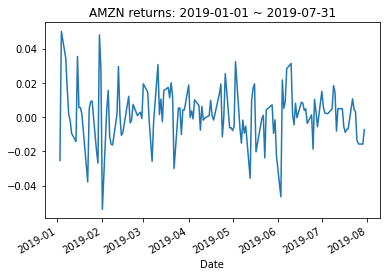

In [ ]:
adj_close=df['Adj Close']
returns=adj_close.pct_change().dropna()
print(f'Average return: {100*returns.mean():.2f}%')
returns.plot(title=f'{asset} returns: {start_date} ~ {end_date}')

In [ ]:
returns.head()

Date
2019-01-03   -0.025242
2019-01-04    0.050064
2019-01-07    0.034353
2019-01-08    0.016612
2019-01-09    0.001714
Name: Adj Close, dtype: float64

In [ ]:
train=returns['2019-01-01':'2019-06-30']
test=returns['2019-07-01':'2019-12-31']

In [ ]:
train.index[-1].date()

datetime.date(2019, 6, 28)

In [ ]:
T=len(test)
N=len(test)
s_0=adj_close[train.index[-1]]
n_sim=100
mu=train.mean()
sigma=train.std()

In [ ]:
def simulate_gbm(s_0,mu,sigma,n_sims,T,N):
    dt=T/N
    dw=np.random.normal(scale=np.sqrt(dt),size=(n_sim,N))
    W=np.cumsum(dw,axis=1)

    time_step=np.linspace(dt,T,N)
    time_steps=np.broadcast_to(time_step,(n_sims,N))

    S_t = s_0 *np.exp((mu-0.5*sigma**2)*time_steps+sigma*W)

    S_t=np.insert(S_t,0,s_0,axis=1)
    return S_t

In [ ]:
gbm_simulations=simulate_gbm(s_0,mu,sigma,n_sim,T,N)

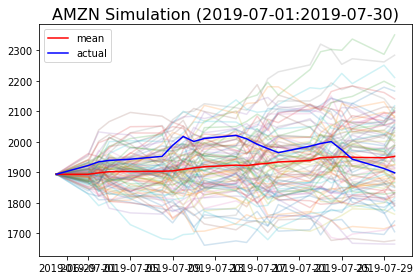

In [ ]:
# prepare objects for plotting 
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{asset} Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
plt.show()

In [ ]:
%timeit gbm_simulations = simulate_gbm(s_0, mu, sigma, n_sim, T, N)

1000 loops, best of 5: 245 µs per loop


In [ ]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, antithetic_var=False):
    np.random.seed(random_seed)
    
    # time increment
    dt = T/N
    
    # Brownian
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, N + 1))
  
    # simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, 
                                 axis=1)) 
    S_t[:, 0] = s_0
    
    return S_t

In [ ]:
%timeit gbm_simulations = simulate_gbm(s_0, mu, sigma, n_sim, T, N)

The slowest run took 10.13 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 160 µs per loop


In [ ]:
%timeit gbm_simulations = simulate_gbm(s_0, mu, sigma, n_sim, T, N, antithetic_var=True)

The slowest run took 5.49 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 120 µs per loop
